# Loan Approval Classifier Project
---

In [66]:
#All the imports

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

---
### Now lets load the dataset and take a look at the first few rows.
---

In [67]:
loanDB = pd.read_csv('../../data/loan_data.csv')
loanDB.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


---
- our target variable is 'loan_status' which indicates whether the loan was approved or not.
---

In [68]:
print(loanDB.shape)
loanDB.info()

(45000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaul

C:\Users\AbdulHadiSaqib\AppData\Local\Temp\ipykernel_6972\2083404105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, ax=axes[i], palette='pastel')
C:\Users\AbdulHadiSaqib\AppData\Local\Temp\ipykernel_6972\2083404105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, ax=axes[i], palette='pastel')
C:\Users\AbdulHadiSaqib\AppData\Local\Temp\ipykernel_6972\2083404105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.

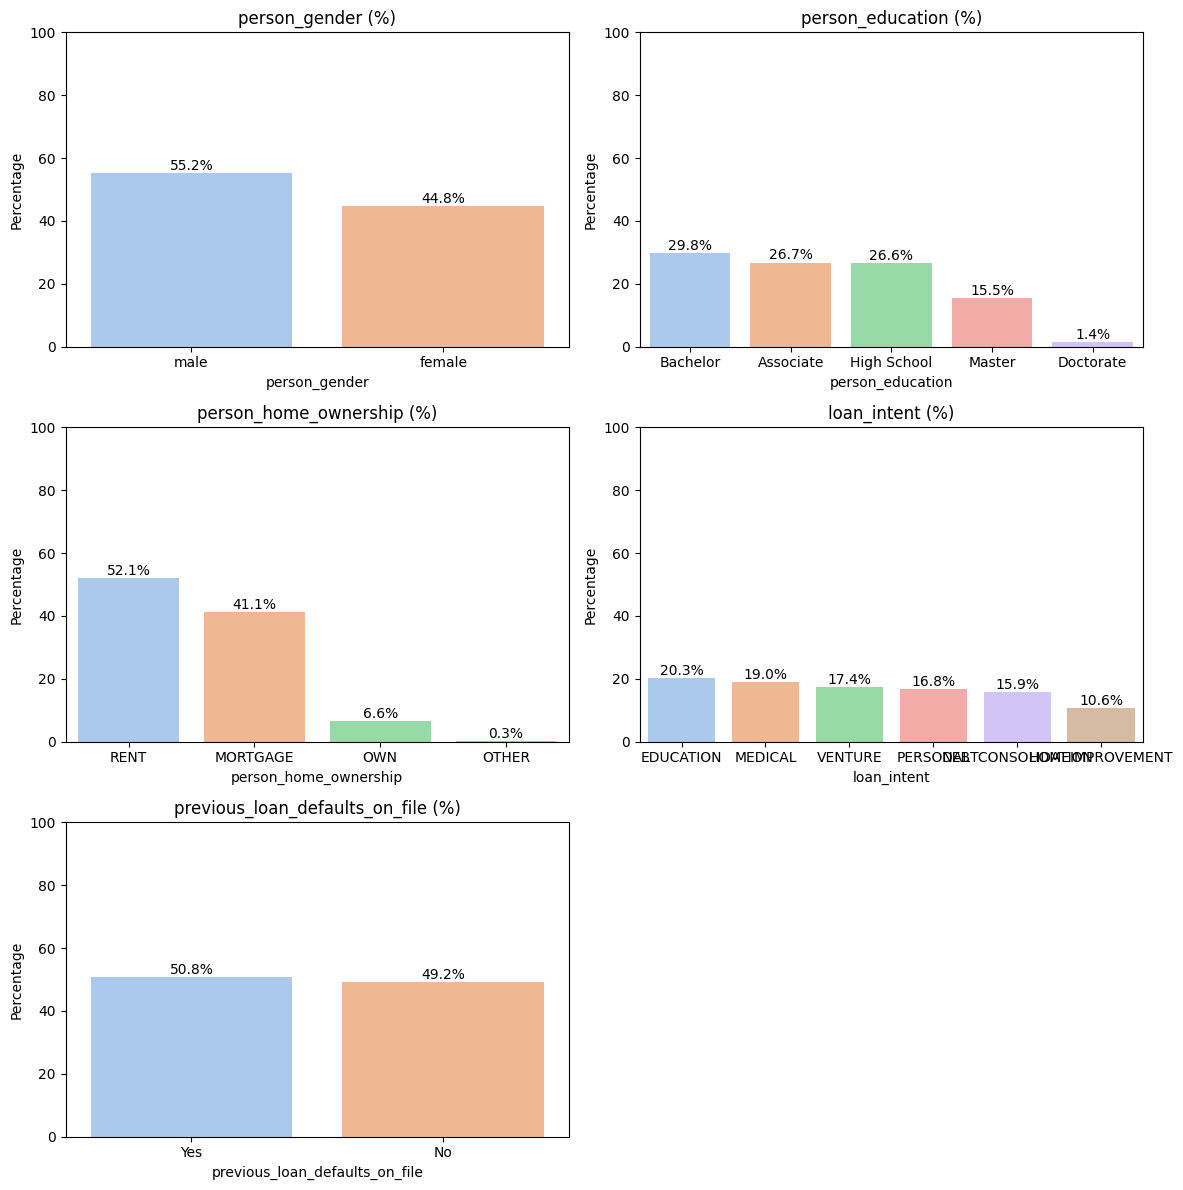

In [69]:

demographics = loanDB[loanDB.select_dtypes(include=['object']).columns]
n_cols = 2  # Number of columns in subplot grid
n_rows = int(np.ceil(len(demographics.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(demographics.columns):
    percentages = loanDB[col].value_counts(normalize=True) * 100
    sns.barplot(x=percentages.index, y=percentages.values, ax=axes[i], palette='pastel')
    axes[i].set_title(f"{col} (%)")
    axes[i].set_ylabel('Percentage')
    axes[i].set_ylim(0, 100)
    for j, v in enumerate(percentages.values):
        axes[i].text(j, v + 1, f"{v:.1f}%", ha='center')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Now lets check for na and remove if they exist

In [70]:
loanDB.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

## More insights of the dataset


In [71]:
object_features = loanDB.select_dtypes(include=['object']).columns.tolist()
print(object_features)

['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


In [72]:
loanDB[object_features]

,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
0,female,Master,RENT,PERSONAL,No
1,female,High School,OWN,EDUCATION,Yes
2,female,High School,MORTGAGE,MEDICAL,No
3,female,Bachelor,RENT,MEDICAL,No
4,male,Master,RENT,MEDICAL,No
...,...,...,...,...,...
44995,male,Associate,RENT,MEDICAL,No
44996,female,Associate,RENT,HOMEIMPROVEMENT,No
44997,male,Associate,RENT,DEBTCONSOLIDATION,No
44998,male,Bachelor,RENT,EDUCATION,No


---
### Lets check for outliers and deal with them
---

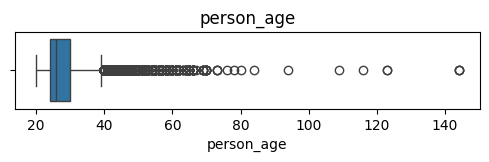

Total percent of outliers in person_age: 4.86%


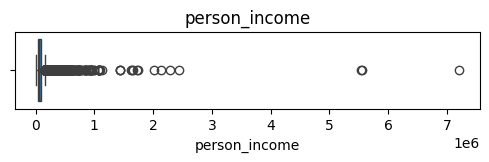

Total percent of outliers in person_income: 4.93%


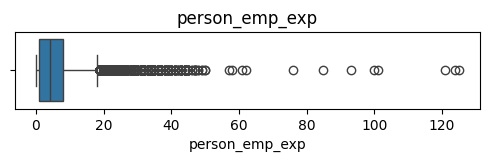

Total percent of outliers in person_emp_exp: 3.83%


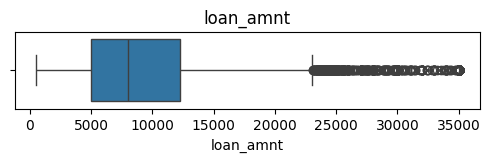

Total percent of outliers in loan_amnt: 5.22%


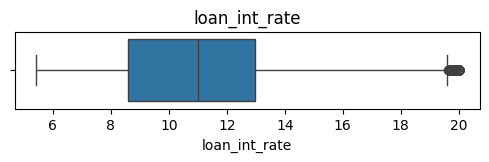

Total percent of outliers in loan_int_rate: 0.28%


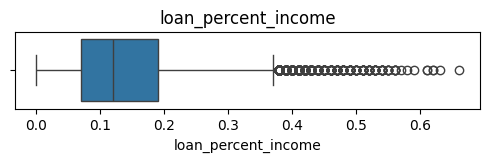

Total percent of outliers in loan_percent_income: 1.65%


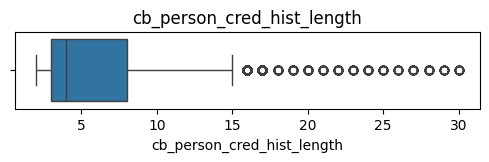

Total percent of outliers in cb_person_cred_hist_length: 3.04%


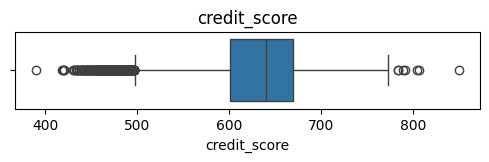

Total percent of outliers in credit_score: 1.04%


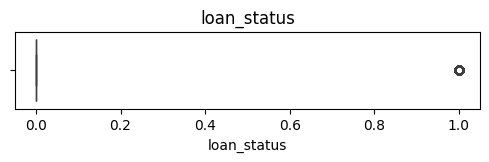

Total percent of outliers in loan_status: 22.22%


In [73]:

for col in loanDB.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 1))
    sns.boxplot(x=loanDB[col])
    plt.title(col)
    plt.show()
    q1 = loanDB[col].quantile(0.25)
    q3 = loanDB[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = loanDB[(loanDB[col] < lower_bound) | (loanDB[col] > upper_bound)]
    percent_outliers = (len(outliers) / len(loanDB)) * 100
    print(f"Total percent of outliers in {col}: {percent_outliers:.2f}%")


- Lets Cap the outliers in the numerical columns
---

In [74]:
cols = ['loan_amnt', 'person_income', 'loan_percent_income']

for col in cols:
    q1 = loanDB[col].quantile(0.25)
    q3 = loanDB[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    loanDB[col] = loanDB[col].clip(lower=lower_bound, upper=upper_bound)

- So not much correlation with anyone but loan_percent_income , loan_int_rate have a good correlation while loan amount and person_income have a healthy correlation 

---
- will apply binary encoding in : gender and previous loan status
- And will apply  Ordinal Encoding on: education
- While one hot on the rest of the columns
---

In [75]:
# Only encode if dtype is object (not already numeric)
if loanDB['person_gender'].dtype == 'object':
    loanDB['person_gender'] = loanDB['person_gender'].map({'female': 0, 'male': 1})

if loanDB['previous_loan_defaults_on_file'].dtype == 'object':
    loanDB['previous_loan_defaults_on_file'] = loanDB['previous_loan_defaults_on_file'].map({'No': 0, 'Yes': 1})

In [76]:
#lets do label encoding on education
if loanDB['person_education'].dtype == 'object':
    loanDB['person_education'] = loanDB['person_education'].map({
        'High School': 0,
        'Associate': 1,
        'Bachelor': 2,
        'Master': 3,
        'Doctorate': 4
    })

In [77]:
loanDB['person_education'].value_counts()

person_education
2    13399
1    12028
0    11972
3     6980
4      621
Name: count, dtype: int64

In [78]:
#One hot encoding for categorical variables
categorical_features = loanDB.select_dtypes(include=['object']).columns.tolist()
categorical_features

['person_home_ownership', 'loan_intent']

In [79]:
loanDB['person_home_ownership'].value_counts()

person_home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

In [80]:
loanDB = pd.get_dummies(loanDB, columns=['person_home_ownership', 'loan_intent'], drop_first=True)

In [81]:
loanDB.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22.0,0,3,71948.0,0,23093.125,16.02,0.37,3.0,561,0,1,False,False,True,False,False,False,True,False
1,21.0,0,0,12282.0,0,1000.000,11.14,0.08,2.0,504,1,0,False,True,False,True,False,False,False,False
2,25.0,0,0,12438.0,3,5500.000,12.87,0.37,3.0,635,0,1,False,False,False,False,False,True,False,False
3,23.0,0,2,79753.0,0,23093.125,15.23,0.37,2.0,675,0,1,False,False,True,False,False,True,False,False
4,24.0,1,3,66135.0,1,23093.125,14.27,0.37,4.0,586,0,1,False,False,True,False,False,True,False,False


In [82]:
# Now lets change the age to int
loanDB['person_age'] = loanDB['person_age'].astype(int)
print(loanDB['person_age'].dtype)

int64


---
- Now lets do the correlation stuff
---

Correlation with loan_status:
loan_status                       1.000000
loan_percent_income               0.384660
loan_int_rate                     0.332005
person_home_ownership_RENT        0.255239
loan_amnt                         0.107306
loan_intent_MEDICAL               0.065195
loan_intent_HOMEIMPROVEMENT       0.033838
person_home_ownership_OTHER       0.013645
person_gender                    -0.000561
person_education                 -0.001108
credit_score                     -0.007647
cb_person_cred_hist_length       -0.014851
person_emp_exp                   -0.020481
person_age                       -0.021476
loan_intent_PERSONAL             -0.022488
loan_intent_EDUCATION            -0.064006
loan_intent_VENTURE              -0.085992
person_home_ownership_OWN        -0.093666
person_income                    -0.249146
previous_loan_defaults_on_file   -0.543096
Name: loan_status, dtype: float64


C:\Users\AbdulHadiSaqib\AppData\Local\Temp\ipykernel_6972\1332819844.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr_filtered.values, y=target_corr_filtered.index, palette='coolwarm')


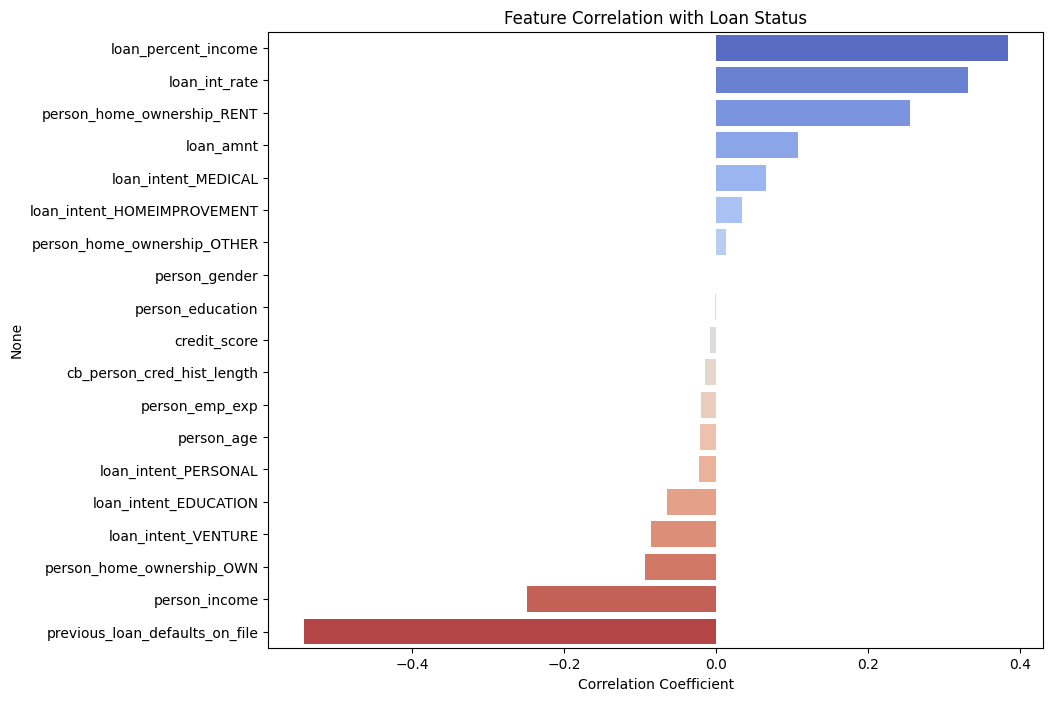

In [83]:
# Correlation with target variable only
target_corr = loanDB.corr()['loan_status'].sort_values(ascending=False)
print("Correlation with loan_status:")
print(target_corr)

# Visualize correlations with target variable
plt.figure(figsize=(10, 8))
target_corr_filtered = target_corr.drop('loan_status')  # Remove self-correlation
sns.barplot(x=target_corr_filtered.values, y=target_corr_filtered.index, palette='coolwarm')
plt.title('Feature Correlation with Loan Status')
plt.xlabel('Correlation Coefficient')
plt.show()

In [84]:
loanDB.drop(columns=['person_gender','person_education','credit_score','person_emp_exp' ,'cb_person_cred_hist_length','person_age'], inplace=True)

In [85]:
loanDB.shape

(45000, 14)

In [86]:
loanDB.dtypes

person_income                     float64
loan_amnt                         float64
loan_int_rate                     float64
loan_percent_income               float64
previous_loan_defaults_on_file      int64
loan_status                         int64
person_home_ownership_OTHER          bool
person_home_ownership_OWN            bool
person_home_ownership_RENT           bool
loan_intent_EDUCATION                bool
loan_intent_HOMEIMPROVEMENT          bool
loan_intent_MEDICAL                  bool
loan_intent_PERSONAL                 bool
loan_intent_VENTURE                  bool
dtype: object

In [87]:
from statsmodels.tools.tools import add_constant

X = loanDB.drop(columns=['loan_status'])  
X = X.astype({col: int for col in X.select_dtypes(include='bool').columns})

# target column
X = add_constant(X)  # adds intercept term

vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                           feature        VIF
0                            const  47.009324
1                    person_income   4.399825
2                        loan_amnt   6.052647
3                    loan_int_rate   1.078002
4              loan_percent_income   5.790769
5   previous_loan_defaults_on_file   1.099179
6      person_home_ownership_OTHER   1.005173
7        person_home_ownership_OWN   1.143792
8       person_home_ownership_RENT   1.292601
9            loan_intent_EDUCATION   1.830347
10     loan_intent_HOMEIMPROVEMENT   1.505193
11             loan_intent_MEDICAL   1.789195
12            loan_intent_PERSONAL   1.720839
13             loan_intent_VENTURE   1.761751


---
- As loan_percent_income is derived from person_income and loan_amount, we can drop person_income and loan_amount
---

In [88]:
loanDB.drop(columns =['loan_amnt','person_income'], inplace=True)

In [89]:
loanDB.head()

,loan_int_rate,loan_percent_income,previous_loan_defaults_on_file,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,16.02,0.37,0,1,False,False,True,False,False,False,True,False
1,11.14,0.08,1,0,False,True,False,True,False,False,False,False
2,12.87,0.37,0,1,False,False,False,False,False,True,False,False
3,15.23,0.37,0,1,False,False,True,False,False,True,False,False
4,14.27,0.37,0,1,False,False,True,False,False,True,False,False
